In [2]:
!pip install emoji
!pip install transformers

     |████████████████████████████████| 133kB 5.0MB/s 
     |████████████████████████████████| 2.5MB 5.0MB/s 
     |████████████████████████████████| 901kB 36.0MB/s 
     |████████████████████████████████| 3.3MB 29.9MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Thư viện

In [4]:
from numpy import mean
from numpy import std
import emoji
from sklearn.naive_bayes import ComplementNB
import seaborn as sb
from gensim.models import KeyedVectors

import keras
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from keras.utils.np_utils import to_categorical
from sklearn.multioutput import MultiOutputClassifier
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dense, Flatten, Dropout, LSTM, Bidirectional, GRU
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.svm import SVC
from keras.models import load_model
from joblib import dump
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Đọc dữ liệu

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/NLP for Data Science/NLP_Project/Data_csv/APD_data/Head/APD_train_head.csv')
df_dev = pd.read_csv('/content/drive/MyDrive/NLP for Data Science/NLP_Project/Data_csv/APD_data/Head/APD_dev_head.csv')
df_test = pd.read_csv('/content/drive/MyDrive/NLP for Data Science/NLP_Project/Data_csv/APD_data/Head/APD_test_head.csv')

df_train.head(10)

,text,polarity
0,đồ uống giá tiền Giá 53k size vừa.,1
1,đồ uống loại Giá 53k size vừa.,1
2,nhà hàng giá tiền Nhưng nói chung cũng hơi đắt.,0
3,thức ăn chất lượng Mình ăn rất hôi mùi dầu.,0
4,thức ăn chất lượng Mình ăn chưa baoh thấy mùi ...,2
5,nhà hàng giá tiền 3 dĩa vs 2 lon Revive mà có ...,2
6,nhà hàng tổng quát Ở đây ngay khu vắng nên khá...,1
7,"nhà hàng tổng quát Quán đông lắm, gọi món phải...",2
8,"phục vụ tổng quát Quán đông lắm, gọi món phải ...",0
9,đồ uống chất lượng Mình uống trà sữa lài hạnh ...,2


# Hàm tiền xử lý

In [6]:
# Xóa code html
def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

# xóa link
def remove_url(document):
    document = re.sub(r"(http\S+)|(www\S+)", '', document)
    return document

# xóa tag user
def remove_tag_user(document):
    document = re.sub(r"(@\w{1,15})", '', document)
    return document

# xóa hashtags
def remove_hashtags(document):
    document = re.sub("#(\w{1,})", '', document)
    return document

# Chuẩn hóa unicode
import regex as re
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
dicchar = loaddicchar()
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

# Chuẩn hóa dấu tiếng việt
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word
    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9: 
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5: 
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word
    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)
    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True
def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

# VNCoreNLP tách từ
!pip install deplacy vncorenlp
!test -d VnCoreNLP || git clone --depth=1 https://github.com/vncorenlp/VnCoreNLP
from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar",annotators="wseg")
def vncore_tokenize(document):
    l = vncorenlp.tokenize(document)[0]
    document = ''
    for i in range(len(l)):
        document += l[i] + ' '
    document = document[:-1]
    return document

# Stopword
def stopword(path):
    stopwords = []
    f = open(path, 'r')
    for line in f:
        line = line.rstrip()
        line = line.replace(' ', '_')
        stopwords.append(line)
    f.close()
    return stopwords
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/vietnamese-stopwords.txt'
stopwords = stopword(path)
def remove_stopword(text):
    text_new = ''
    list_word = text.split()
    for word in list_word:
        if word not in stopwords:
            text_new += word + ' '
    text_new = text_new[:-1]
    return text_new

# Chuẩn hóa từ về dạng chuẩn (ngonnnn thành ngon)
def standardize_word(text):
    new_text = []
    for i in range(len(text)):
        if i == 0 or (text[i-1] != text[i]):
            new_text.append(text[i])
    new_text = "".join(new_text)
    return new_text

# Chuyển emotion, emoji thành word form
def load_emoticon_to_word_dict(file_path):
    the_dict = pd.read_excel(file_path).to_dict()
    emoticon_to_word = dict((v,key) for key,value in the_dict.items() for v in value.values() if type(v) is str)
    return emoticon_to_word
def load_word_dict_to_vietnameses(file_path):
    eng_to_vie_df = pd.read_excel(file_path)
    eng_to_vie = dict(zip(eng_to_vie_df.Emojize, eng_to_vie_df.Translated))
    return eng_to_vie
emoticon_to_word = load_emoticon_to_word_dict("/content/drive/MyDrive/NLP for Data Science/NLP_Project/emoticon-emoji.xlsx")
word_to_vietnamese = load_word_dict_to_vietnameses("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Emoji_to_VN.xlsx")
punct_to_remove = """(<[/:.,;`~-'"@#*+=\]>)"""
def emo_to_word_form(text, emoticon_to_word, punct_to_remove):
    #Change emoji to word form
    new_text = emoji.demojize(text)
    #Change emoticon to word form
    word_list = [emoticon_to_word[k] if k in emoticon_to_word.keys() else k for k in new_text.split(" ")] 
    new_text = " ".join(word_list)
    #Add space between punctuations such as ([:.,!?()])
    new_text = re.sub('([:.,!?()])', r' \1 ', new_text) 
    #Remove some punctuation
    text_remove_punct = [new_text[i] if new_text[i] not in punct_to_remove else '' for i in range(len(new_text))]
    new_text = "".join(text_remove_punct)
    #Remove extra space
    new_text = re.sub(' +', ' ', new_text)
    new_text = re.sub(r'\s+', ' ', new_text).strip()
    return new_text

# Chuyển word form sang tiếng việt
def work_form_to_vietnamese(text, word_to_vietnamese):
    word_list_word_to_viet = []
    for word in text.split(" "):
        if word in word_to_vietnamese.keys():
            word = word_to_vietnamese[word]
        if '_' in word:
            continue
        word_list_word_to_viet.append(word)
    new_text = " ".join(word_list_word_to_viet)
    return new_text

# Chuyển 100k thành giá tiền
def money(text):
    text = re.sub('(\d+k)|(\d+ k)|(\d+đồng)|(\d+ đồng)|(\d+ngàn)|(\d+ ngàn)|(\d+nghìn)|(\d+ nghìn)', 'giá tiền', text)
    return text

     |████████████████████████████████| 2.7MB 6.7MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=248188d1c226e1ef8f1fc91730b5c60177e1f51bf9d529bd10b2981ecf83ff9b
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 54 (delta 1), reused 41 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [7]:
# Preprocessing final
def text_preprocess(document):
    # chuẩn hóa unicode
    document = convert_unicode(document)
    # chuẩn hóa cách gõ dấu tiếng Việt
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # xóa html code
    document = remove_html(document)
    # xóa link
    document =  remove_url(document)
    # xóa tag user
    document = remove_tag_user(document)
    # xóa hashtags
    document =  remove_hashtags(document)
    # Đưa từ về dạng chuẩn
    document = standardize_word(document)
    # Chuyển emotion, emoji thành word form
    document = emo_to_word_form(document, emoticon_to_word, punct_to_remove)
    # Chuyển word form sang Vietnamese.
    document = work_form_to_vietnamese(document, word_to_vietnamese)
    # Chuẩn hóa giá tiền
    document = money(document)
    # tách từ
    document = vncore_tokenize(document)
    # # đưa về lower
    document = document.lower()
    # # xóa stopword
    document = remove_stopword(document)
    # # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]', ' ', document)
    # # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()

    return document

In [8]:
# Tiền xử lý comment
def preprocessing_comment(df):
    for i in range(len(df)):
        comment = df['text'][i]
        df['text'][i] = text_preprocess(comment)
    return df

df_train = preprocessing_comment(df_train)
df_dev = preprocessing_comment(df_dev)
df_test = preprocessing_comment(df_test)

df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,polarity
0,đồ uống giá tiền giá giá tiền size,1
1,đồ uống giá giá tiền size,1
2,nhà_hàng giá tiền hơi đắt,0
3,thức_ăn chất_lượng hôi mùi dầu,0
4,thức_ăn chất_lượng baoh mùi hôi hải_sản,2


# X và y

In [9]:
X_train = df_train['text'].values
X_dev = df_dev['text'].values
X_test = df_test['text'].values

y_train = df_train['polarity'].values
y_dev = df_dev['polarity'].values
y_test = df_test['polarity'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


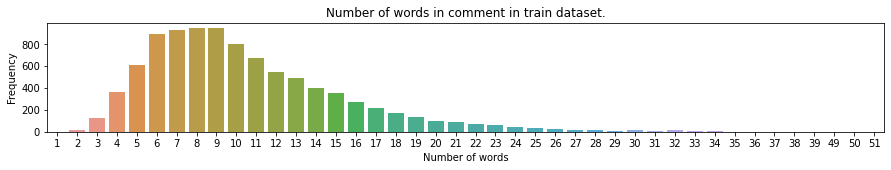

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


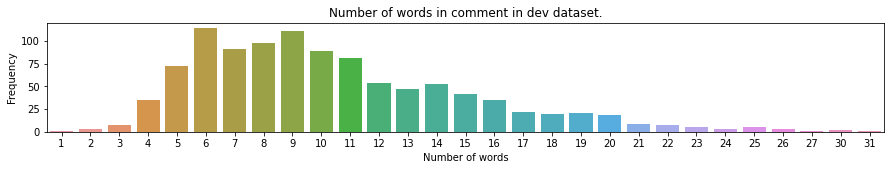

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


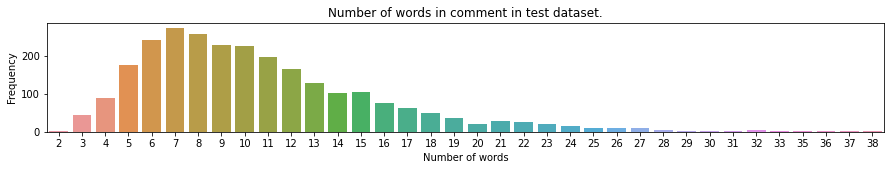

In [10]:
# Độ dài cmt
def plot_number_word(X, name):
    l = []
    for i in range(len(X)):
        l.append(len(X[i].split()))
    plt.figure(figsize = (15, 2))
    sb.countplot(l)
    plt.title("Number of words in comment in " + name + ' dataset.')
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.show()

plot_number_word(X_train, 'train')
plot_number_word(X_dev, 'dev')
plot_number_word(X_test, 'test')

# ================================================================

In [11]:
model_name = ["Native Bayes",
              "Logistic Regression",
              "SVM",
              "Text-CNN-fastText",
              "Text-CNN-Wikipedia Word2vec",
              "Text-CNN-BPEmb",
              "Text-CNN-MULTI_WC_F_E_B",
              "Bi-GRU-fastText",
              "Bi-GRU-Wikipedia Word2vec",
              "Bi-GRU-BPEmb",
              "Bi-GRU-MULTI_WC_F_E_B",
              "BERT XLM-R",
              "BERT MULTILINGUAL",
              "FPTAI (cased)",
              "PhoBERT"]

In [12]:
tv = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
x_train = tv.fit_transform(X_train)
x_dev = tv.transform(X_dev)
x_test = tv.transform(X_test)

x_train.shape, x_dev.shape, x_test.shape

((9458, 78314), (1053, 78314), (2629, 78314))

# Model---Naive Bayes

Accuracy train:  0.8821103827447664
Accuracy dev:  0.6419753086419753
Accuracy test:  0.6744009128946368
F1 macro test:  0.5420125085217303
Recall macro test:  0.5185045138914136
Precision macro test:  0.6967371923838866
F1 micro test:  0.6744009128946368
Recall micro test:  0.6744009128946368
Precision micro test:  0.6744009128946368


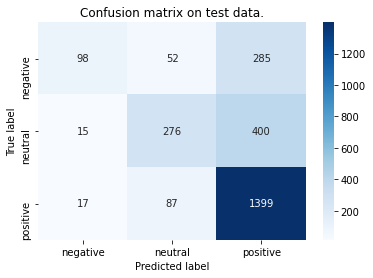

In [ ]:
tv = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
x_train = tv.fit_transform(X_train)
x_dev = tv.transform(X_dev)
x_test = tv.transform(X_test)

model = ComplementNB()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_dev_pred = model.predict(x_dev)
y_test_pred = model.predict(x_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
        xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[0]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = True)

# Model---Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train:  0.8438359061112286
Accuracy dev:  0.6856600189933523
Accuracy test:  0.702548497527577
F1 macro test:  0.6150359017781574
Recall macro test:  0.5878631965958685
Precision macro test:  0.6854491233666461
F1 micro test:  0.702548497527577
Recall micro test:  0.702548497527577
Precision micro test:  0.702548497527577


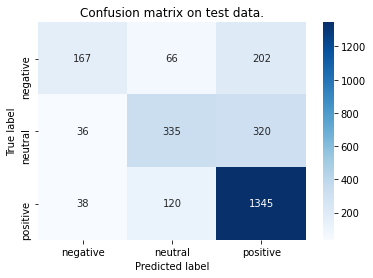

In [ ]:
tv = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
x_train = tv.fit_transform(X_train)
x_dev = tv.transform(X_dev)
x_test = tv.transform(X_test)

model = LogisticRegression()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_dev_pred = model.predict(x_dev)
y_test_pred = model.predict(x_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)

print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[1]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---SVM

Accuracy train:  0.909600338337915
Accuracy dev:  0.671415004748338
Accuracy test:  0.6907569418029669
F1 macro test:  0.5877196882486785
Recall macro test:  0.5570905375015505
Precision macro test:  0.6990000391374114
F1 micro test:  0.6907569418029669
Recall micro test:  0.6907569418029669
Precision micro test:  0.6907569418029669


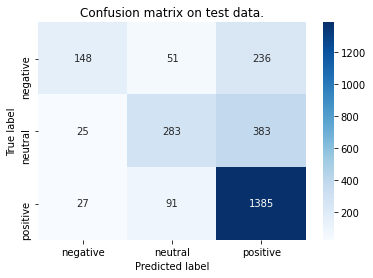

In [ ]:
tv = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3))
x_train = tv.fit_transform(X_train)
x_dev = tv.transform(X_dev)
x_test = tv.transform(X_test)

model = SVC()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_dev_pred = model.predict(x_dev)
y_test_pred = model.predict(x_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[2]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# ========================================================

# Model---Text-CNN---FastText

Epoch 1/10
37/37 [==============================] - 46s 56ms/step - loss: 0.5985 - accuracy: 0.5353 - val_loss: 0.5218 - val_accuracy: 0.6182
Epoch 2/10
37/37 [==============================] - 1s 34ms/step - loss: 0.4655 - accuracy: 0.6684 - val_loss: 0.4585 - val_accuracy: 0.6847
Epoch 3/10
37/37 [==============================] - 1s 33ms/step - loss: 0.3711 - accuracy: 0.7519 - val_loss: 0.4344 - val_accuracy: 0.7075
Epoch 4/10
37/37 [==============================] - 1s 35ms/step - loss: 0.3044 - accuracy: 0.8123 - val_loss: 0.4365 - val_accuracy: 0.7085
Epoch 5/10
37/37 [==============================] - 1s 34ms/step - loss: 0.2593 - accuracy: 0.8504 - val_loss: 0.4563 - val_accuracy: 0.6980
Epoch 6/10
37/37 [==============================] - 1s 34ms/step - loss: 0.2218 - accuracy: 0.8734 - val_loss: 0.4782 - val_accuracy: 0.7075
Epoch 7/10
37/37 [==============================] - 1s 35ms/step - loss: 0.1786 - accuracy: 0.9080 - val_loss: 0.5039 - val_accuracy: 0.6933
Epoch 8/10
3

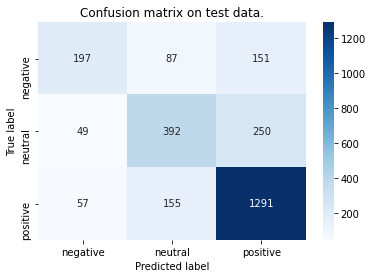

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

# Embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype = np.float32)[:embedding_dim]
    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
embedding_dim = 300
word_vector = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/cc.vi.300.vec'
embedding_matrix = create_embedding_matrix(word_vector, tokenizer.word_index, embedding_dim)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Conv1D(128, 3, activation = 'relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[3]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Text-CNN---Wikipedia Word2vec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Epoch 1/10
37/37 [==============================] - 3s 54ms/step - loss: 0.7223 - accuracy: 0.5441 - val_loss: 0.5143 - val_accuracy: 0.6258
Epoch 2/10
37/37 [==============================] - 2s 41ms/step - loss: 0.4224 - accuracy: 0.7072 - val_loss: 0.4747 - val_accuracy: 0.6695
Epoch 3/10
37/37 [==============================] - 2s 41ms/step - loss: 0.3599 - accuracy: 0.7696 - val_loss: 0.4725 - val_accuracy: 0.6876
Epoch 4/10
37/37 [==============================] - 2s 42ms/step - loss: 0.3044 - accuracy: 0.8183 - val_loss: 0.4858 - val_accuracy: 0.6686
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 0.2641 - accuracy: 0.8567 - val_loss: 0.4976 - val_accuracy: 0.6733
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 0.2290 - accuracy: 0.8819 - val_loss: 0.4981 - val_accuracy: 0.6895
Epoch 7/10
37/37 [==============================] - 2s 41ms/step - loss: 0.1848 - accuracy: 0.9099 - val_loss: 0.5220 - val_accuracy: 0.6857
Epoch 8/10
37

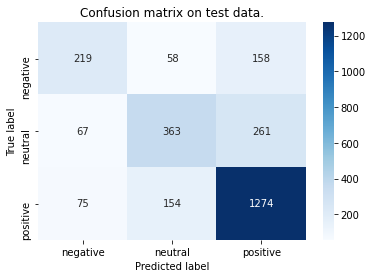

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

def __get_embedding_dict(model_filepath):
    embedding_dict = {}
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    vocab = [(word, word2vec_model.wv[word]) for word, vectors in word2vec_model.wv.vocab.items()]

    for i in range(len(vocab)):
        word = vocab[i][0]
        vectors = vocab[i][1]
        embedding_dict[word] = vectors

    return embedding_dict
def create_embedding_matrix(model_filepath, word2id):

    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    embeddings_dict = __get_embedding_dict(model_filepath)
    embedding_matrix = np.zeros((len(word2id) + 1, word2vec_model.vector_size))
    for word, idx in word2id.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

maxlen = 30
embedding_dim = 400
vocab_size = len(tokenizer.word_index) + 1
model_filepath = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/wiki.vi.model.bin'
embedding_matrix = create_embedding_matrix(model_filepath, tokenizer.word_index)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Conv1D(128, 3, activation = 'relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[4]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Text-CNN---BPEmb

     |████████████████████████████████| 1.2MB 5.8MB/s 
downloading https://nlp.h-its.org/bpemb/vi/vi.wiki.bpe.vs200000.model


100%|██████████| 3659179/3659179 [00:01<00:00, 2003152.42B/s]


downloading https://nlp.h-its.org/bpemb/vi/vi.wiki.bpe.vs200000.d300.w2v.bin.tar.gz


100%|██████████| 223674818/223674818 [00:27<00:00, 8179605.11B/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


Epoch 1/10
37/37 [==============================] - 3s 44ms/step - loss: 0.6030 - accuracy: 0.5105 - val_loss: 0.5181 - val_accuracy: 0.6182
Epoch 2/10
37/37 [==============================] - 1s 35ms/step - loss: 0.4645 - accuracy: 0.6665 - val_loss: 0.4734 - val_accuracy: 0.6629
Epoch 3/10
37/37 [==============================] - 1s 34ms/step - loss: 0.3882 - accuracy: 0.7432 - val_loss: 0.4470 - val_accuracy: 0.6847
Epoch 4/10
37/37 [==============================] - 1s 36ms/step - loss: 0.3188 - accuracy: 0.8028 - val_loss: 0.4402 - val_accuracy: 0.7066
Epoch 5/10
37/37 [==============================] - 1s 35ms/step - loss: 0.2644 - accuracy: 0.8524 - val_loss: 0.4554 - val_accuracy: 0.6999
Epoch 6/10
37/37 [==============================] - 1s 35ms/step - loss: 0.2142 - accuracy: 0.8868 - val_loss: 0.4651 - val_accuracy: 0.7170
Epoch 7/10
37/37 [==============================] - 1s 33ms/step - loss: 0.1659 - accuracy: 0.9178 - val_loss: 0.4931 - val_accuracy: 0.7075
Epoch 8/10
37

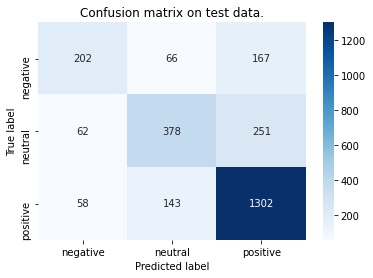

In [ ]:
!pip install bpemb

x_train = X_train
x_dev = X_dev
x_test = X_test

from bpemb import BPEmb
bpemb_vi = BPEmb(lang = 'vi', dim = 300, vs = 200000)

def __get_embedding_dict(model_filepath):
    embedding_dict = {}
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    vocab = [(word, word2vec_model.wv[word]) for word, vectors in word2vec_model.wv.vocab.items()]
    for i in range(len(vocab)):
        word = vocab[i][0]
        vectors = vocab[i][1]
        embedding_dict[word] = vectors
    return embedding_dict

def create_embedding_matrix(model_filepath, word2id):
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    embeddings_dict = __get_embedding_dict(model_filepath)
    embedding_matrix = np.zeros((len(word2id) + 1, word2vec_model.vector_size))
    for word, idx in word2id.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

maxlen = 30
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
model_filepath = bpemb_vi.emb_file
embedding_matrix = create_embedding_matrix(model_filepath, tokenizer.word_index)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Conv1D(128, 3, activation = 'relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[5]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Text-CNN---MULTI_WC_F_E_B

Epoch 1/10
37/37 [==============================] - 3s 45ms/step - loss: 0.6012 - accuracy: 0.5480 - val_loss: 0.5300 - val_accuracy: 0.6087
Epoch 2/10
37/37 [==============================] - 1s 35ms/step - loss: 0.4811 - accuracy: 0.6444 - val_loss: 0.4533 - val_accuracy: 0.6876
Epoch 3/10
37/37 [==============================] - 1s 36ms/step - loss: 0.3796 - accuracy: 0.7415 - val_loss: 0.4319 - val_accuracy: 0.7151
Epoch 4/10
37/37 [==============================] - 1s 36ms/step - loss: 0.3056 - accuracy: 0.8074 - val_loss: 0.4385 - val_accuracy: 0.7047
Epoch 5/10
37/37 [==============================] - 1s 37ms/step - loss: 0.2552 - accuracy: 0.8537 - val_loss: 0.4527 - val_accuracy: 0.7104
Epoch 6/10
37/37 [==============================] - 1s 36ms/step - loss: 0.2127 - accuracy: 0.8776 - val_loss: 0.4845 - val_accuracy: 0.7018
Epoch 7/10
37/37 [==============================] - 1s 37ms/step - loss: 0.1686 - accuracy: 0.9105 - val_loss: 0.5083 - val_accuracy: 0.7085
Epoch 8/10
37

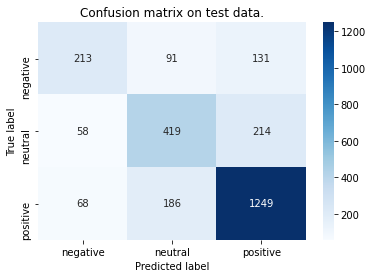

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

# Embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype = np.float32)[:embedding_dim]
    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
embedding_dim = 300
word_vector = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/MULTI_W_F_B_E.vec'
embedding_matrix = create_embedding_matrix(word_vector, tokenizer.word_index, embedding_dim)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Conv1D(128, 3, activation = 'relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[6]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# =============================================

# Model---Bi-GRU---FastText

Epoch 1/10
37/37 [==============================] - 15s 86ms/step - loss: 0.6251 - accuracy: 0.4904 - val_loss: 0.5529 - val_accuracy: 0.5518
Epoch 2/10
37/37 [==============================] - 2s 53ms/step - loss: 0.5193 - accuracy: 0.5911 - val_loss: 0.4712 - val_accuracy: 0.6676
Epoch 3/10
37/37 [==============================] - 2s 52ms/step - loss: 0.4167 - accuracy: 0.7050 - val_loss: 0.4401 - val_accuracy: 0.7018
Epoch 4/10
37/37 [==============================] - 2s 52ms/step - loss: 0.3522 - accuracy: 0.7722 - val_loss: 0.4480 - val_accuracy: 0.6952
Epoch 5/10
37/37 [==============================] - 2s 53ms/step - loss: 0.3197 - accuracy: 0.7961 - val_loss: 0.4602 - val_accuracy: 0.6990
Epoch 6/10
37/37 [==============================] - 2s 53ms/step - loss: 0.2964 - accuracy: 0.8152 - val_loss: 0.4927 - val_accuracy: 0.6990
Epoch 7/10
37/37 [==============================] - 2s 53ms/step - loss: 0.2588 - accuracy: 0.8442 - val_loss: 0.5107 - val_accuracy: 0.6895
Epoch 8/10
3

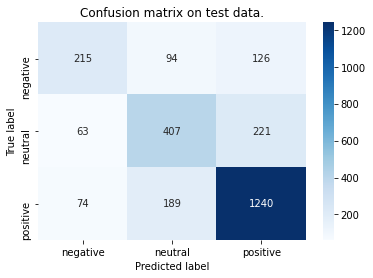

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

# Embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype = np.float32)[:embedding_dim]
    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
embedding_dim = 300
word_vector = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/cc.vi.300.vec'
embedding_matrix = create_embedding_matrix(word_vector, tokenizer.word_index, embedding_dim)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[7]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Bi-GRU---Wikipedia Word2vec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Epoch 1/10
37/37 [==============================] - 8s 96ms/step - loss: 0.6023 - accuracy: 0.5030 - val_loss: 0.5338 - val_accuracy: 0.5926
Epoch 2/10
37/37 [==============================] - 2s 63ms/step - loss: 0.5052 - accuracy: 0.6219 - val_loss: 0.4750 - val_accuracy: 0.6486
Epoch 3/10
37/37 [==============================] - 2s 62ms/step - loss: 0.4324 - accuracy: 0.6949 - val_loss: 0.4514 - val_accuracy: 0.7056
Epoch 4/10
37/37 [==============================] - 2s 62ms/step - loss: 0.3826 - accuracy: 0.7467 - val_loss: 0.4480 - val_accuracy: 0.7085
Epoch 5/10
37/37 [==============================] - 2s 62ms/step - loss: 0.3606 - accuracy: 0.7641 - val_loss: 0.4480 - val_accuracy: 0.7189
Epoch 6/10
37/37 [==============================] - 2s 62ms/step - loss: 0.3348 - accuracy: 0.7778 - val_loss: 0.4655 - val_accuracy: 0.7094
Epoch 7/10
37/37 [==============================] - 2s 62ms/step - loss: 0.3036 - accuracy: 0.8122 - val_loss: 0.4669 - val_accuracy: 0.7104
Epoch 8/10
37

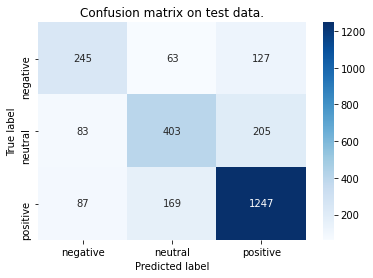

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

def __get_embedding_dict(model_filepath):
    embedding_dict = {}
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    vocab = [(word, word2vec_model.wv[word]) for word, vectors in word2vec_model.wv.vocab.items()]

    for i in range(len(vocab)):
        word = vocab[i][0]
        vectors = vocab[i][1]
        embedding_dict[word] = vectors

    return embedding_dict

def create_embedding_matrix(model_filepath, word2id):
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    embeddings_dict = __get_embedding_dict(model_filepath)
    embedding_matrix = np.zeros((len(word2id) + 1, word2vec_model.vector_size))
    for word, idx in word2id.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

maxlen = 30
embedding_dim = 400
vocab_size = len(tokenizer.word_index) + 1
model_filepath = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/wiki.vi.model.bin'
embedding_matrix = create_embedding_matrix(model_filepath, tokenizer.word_index)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[8]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Bi-GRU---BPEmb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


Epoch 1/10
37/37 [==============================] - 8s 87ms/step - loss: 0.6011 - accuracy: 0.5448 - val_loss: 0.5447 - val_accuracy: 0.5869
Epoch 2/10
37/37 [==============================] - 2s 53ms/step - loss: 0.5117 - accuracy: 0.6129 - val_loss: 0.4851 - val_accuracy: 0.6477
Epoch 3/10
37/37 [==============================] - 2s 53ms/step - loss: 0.4391 - accuracy: 0.6853 - val_loss: 0.4464 - val_accuracy: 0.6885
Epoch 4/10
37/37 [==============================] - 2s 53ms/step - loss: 0.3839 - accuracy: 0.7364 - val_loss: 0.4407 - val_accuracy: 0.6933
Epoch 5/10
37/37 [==============================] - 2s 53ms/step - loss: 0.3508 - accuracy: 0.7691 - val_loss: 0.4380 - val_accuracy: 0.7104
Epoch 6/10
37/37 [==============================] - 2s 53ms/step - loss: 0.3289 - accuracy: 0.7855 - val_loss: 0.4621 - val_accuracy: 0.7066
Epoch 7/10
37/37 [==============================] - 2s 52ms/step - loss: 0.2899 - accuracy: 0.8211 - val_loss: 0.4532 - val_accuracy: 0.7018
Epoch 8/10
37

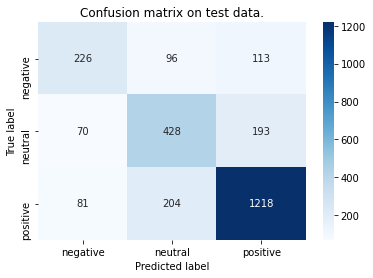

In [ ]:
!pip install bpemb

x_train = X_train
x_dev = X_dev
x_test = X_test

from bpemb import BPEmb
bpemb_vi = BPEmb(lang = 'vi', dim = 300, vs = 200000)

def __get_embedding_dict(model_filepath):
    embedding_dict = {}
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    vocab = [(word, word2vec_model.wv[word]) for word, vectors in word2vec_model.wv.vocab.items()]

    for i in range(len(vocab)):
        word = vocab[i][0]
        vectors = vocab[i][1]
        embedding_dict[word] = vectors

    return embedding_dict

def create_embedding_matrix(model_filepath, word2id):
    """
    Get the embedding matrix of the word2vec model
    :param model_filepath: the file path to the pre-build word2vec model
    :param word2id: the directory mapping from word to id
    :return: the embedding matrix of the word2vec model
    """
    word2vec_model = KeyedVectors.load_word2vec_format(model_filepath, binary=True)
    embeddings_dict = __get_embedding_dict(model_filepath)
    embedding_matrix = np.zeros((len(word2id) + 1, word2vec_model.vector_size))
    for word, idx in word2id.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

maxlen = 30
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
model_filepath = bpemb_vi.emb_file
embedding_matrix = create_embedding_matrix(model_filepath, tokenizer.word_index)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[9]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# Model---Bi-GRU---MULTI_WC_F_E_B

Epoch 1/10
37/37 [==============================] - 8s 84ms/step - loss: 0.6265 - accuracy: 0.5365 - val_loss: 0.5568 - val_accuracy: 0.5499
Epoch 2/10
37/37 [==============================] - 2s 56ms/step - loss: 0.5174 - accuracy: 0.5906 - val_loss: 0.4634 - val_accuracy: 0.6629
Epoch 3/10
37/37 [==============================] - 2s 55ms/step - loss: 0.4209 - accuracy: 0.6992 - val_loss: 0.4430 - val_accuracy: 0.7018
Epoch 4/10
37/37 [==============================] - 2s 53ms/step - loss: 0.3546 - accuracy: 0.7721 - val_loss: 0.4510 - val_accuracy: 0.6904
Epoch 5/10
37/37 [==============================] - 2s 54ms/step - loss: 0.3142 - accuracy: 0.8018 - val_loss: 0.4639 - val_accuracy: 0.6885
Epoch 6/10
37/37 [==============================] - 2s 56ms/step - loss: 0.2883 - accuracy: 0.8221 - val_loss: 0.4963 - val_accuracy: 0.7028
Epoch 7/10
37/37 [==============================] - 2s 55ms/step - loss: 0.2502 - accuracy: 0.8543 - val_loss: 0.5094 - val_accuracy: 0.6828
Epoch 8/10
37

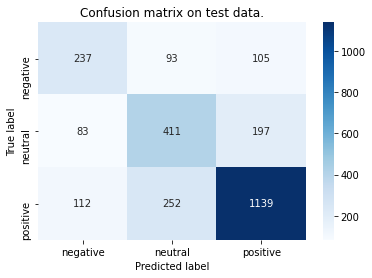

In [ ]:
x_train = X_train
x_dev = X_dev
x_test = X_test

# Embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype = np.float32)[:embedding_dim]
    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
embedding_dim = 300
word_vector = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Word_Embedding/MULTI_W_F_B_E.vec'
embedding_matrix = create_embedding_matrix(word_vector, tokenizer.word_index, embedding_dim)

x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = maxlen, truncating = "post",padding = "post")
x_dev = pad_sequences(x_dev, maxlen = maxlen, truncating = "post",padding = "post")
x_test = pad_sequences(x_test, maxlen = maxlen, truncating = "post",padding = "post")

num_label = 3
epochs = 10
batch_size = 256

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, 
                    weights = [embedding_matrix], input_length = maxlen, trainable = True))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_label, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.summary()

model.fit(x_train, to_categorical(y_train, num_classes = num_label), verbose=1, epochs=epochs,
          batch_size = batch_size, validation_data = (x_dev, to_categorical(y_dev, num_classes = num_label)))

y_train_pred = model.predict(x_train).argmax(axis = -1)
y_dev_pred = model.predict(x_dev).argmax(axis = -1)
y_test_pred = model.predict(x_test).argmax(axis = -1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_dev = accuracy_score(y_dev, y_dev_pred)
acc_test = accuracy_score(y_test, y_test_pred)
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test, y_test_pred, average='micro')
cm = confusion_matrix(y_test, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu record
df = pd.DataFrame({"Model": [model_name[10]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# =========================================================

# BERT XLM-R

https://huggingface.co/xlm-roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpd1lpjpvh


storing https://huggingface.co/xlm-roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
creating metadata file for /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,


https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmppp9ze3jc


storing https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
creating metadata file for /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
loading weights file https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

storing https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
creating metadata file for /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8


https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp338jhgwp


storing https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
creating metadata file for /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7


loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer_config.json from cache at None
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none).

Step,Training Loss
500,0.929400
1000,0.729500
1500,0.588900
2000,0.453500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 9458
  Batch size = 16


***** Running Prediction *****
  Num examples = 1053
  Batch size = 16
***** Running Prediction *****
  Num examples = 2629
  Batch size = 16


Accuracy train:  0.8851765700993868
Accuracy dev:  0.698005698005698
Accuracy test:  0.7367820464054774
F1 macro test:  0.6890173285363437
Recall macro test:  0.6838860164130378
Precision macro test:  0.6956966444575485
F1 micro test:  0.7367820464054774
Recall micro test:  0.7367820464054774
Precision micro test:  0.7367820464054774


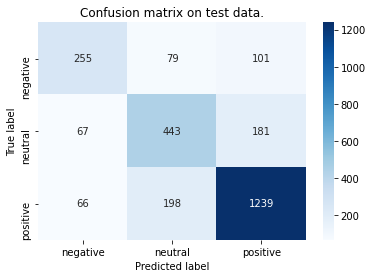

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Khai bao pre-trained
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# encoding du lieu
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

# Chuan bi mo hinh
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 7,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

# Huấn luyện mô hình
trainer.train()

train_dataset_pred = trainer.predict(train_dataset)
dev_dataset_pred = trainer.predict(dev_dataset)
test_dataset_pred = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_dataset_pred.predictions, axis=-1)
y_dev_pred = np.argmax(dev_dataset_pred.predictions, axis=-1)
y_test_pred = np.argmax(test_dataset_pred.predictions, axis=-1)

y_train_true = train_dataset_pred.label_ids
y_dev_true = dev_dataset_pred.label_ids
y_test_true = test_dataset_pred.label_ids

# Danh gia mo hinh
acc_train = accuracy_score(y_train_true, y_train_pred)
acc_dev = accuracy_score(y_dev_true, y_dev_pred)
acc_test = accuracy_score(y_test_true, y_test_pred)
f1_macro_test = f1_score(y_test_true, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test_true, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test_true, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test_true, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test_true, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test_true, y_test_pred, average='micro')
cm = confusion_matrix(y_test_true, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu dự đoán
result = pd.DataFrame([X_test, y_test_true, y_test_pred]).T
result.columns = ['text', 'true_label', 'pred_label']
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Predict CSV/APD_Process/Head'
result.to_csv(path + '/' + 'xlm-r.csv', index=False)
result.head()

# Lưu record
df = pd.DataFrame({"Model": [model_name[11]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# BERT MULTILINGUAL

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3

Step,Training Loss
500,0.855200
1000,0.642900
1500,0.448800
2000,0.265600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 9458
  Batch size = 16


***** Running Prediction *****
  Num examples = 1053
  Batch size = 16
***** Running Prediction *****
  Num examples = 2629
  Batch size = 16


Accuracy train:  0.96331148234299
Accuracy dev:  0.698005698005698
Accuracy test:  0.7238493723849372
F1 macro test:  0.6706673622319773
Recall macro test:  0.6716544897573926
Precision macro test:  0.6697106370247822
F1 micro test:  0.7238493723849372
Recall micro test:  0.7238493723849372
Precision micro test:  0.7238493723849372


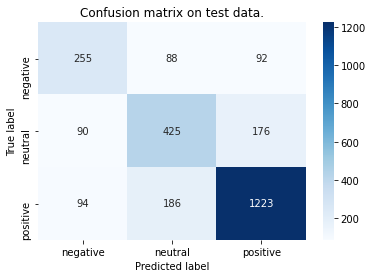

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# encoding du lieu
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

# Chuan bi mo hinh
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 7,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)
# Huấn luyện mô hình
trainer.train()

train_dataset_pred = trainer.predict(train_dataset)
dev_dataset_pred = trainer.predict(dev_dataset)
test_dataset_pred = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_dataset_pred.predictions, axis=-1)
y_dev_pred = np.argmax(dev_dataset_pred.predictions, axis=-1)
y_test_pred = np.argmax(test_dataset_pred.predictions, axis=-1)

y_train_true = train_dataset_pred.label_ids
y_dev_true = dev_dataset_pred.label_ids
y_test_true = test_dataset_pred.label_ids

# Danh gia mo hinh
acc_train = accuracy_score(y_train_true, y_train_pred)
acc_dev = accuracy_score(y_dev_true, y_dev_pred)
acc_test = accuracy_score(y_test_true, y_test_pred)
f1_macro_test = f1_score(y_test_true, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test_true, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test_true, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test_true, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test_true, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test_true, y_test_pred, average='micro')
cm = confusion_matrix(y_test_true, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu dự đoán
result = pd.DataFrame([X_test, y_test_true, y_test_pred]).T
result.columns = ['text', 'true_label', 'pred_label']
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Predict CSV/APD_Process/Head'
result.to_csv(path + '/' + 'bert-multi.csv', index=False)
result.head()

#Lưu record
df = pd.DataFrame({"Model": [model_name[12]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                   "PRECISION-MICRO": [precision_micro_test],
                   "RECALL-MICRO":[recall_micro_test],
                   "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = "a")

# BERT FPTAI/vibert-base-cased



https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbjg3c68z


storing https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/ac830dbe95fda61dfb6f6479706d481dd2c7c2ed4b9064b5fb56ecc53f0ed2fa.7d942d26e554f7243a0055f745a11844b215e58ac9e8a5dc60dbf1ec3c474a71
creating metadata file for /root/.cache/huggingface/transformers/ac830dbe95fda61dfb6f6479706d481dd2c7c2ed4b9064b5fb56ecc53f0ed2fa.7d942d26e554f7243a0055f745a11844b215e58ac9e8a5dc60dbf1ec3c474a71
loading configuration file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ac830dbe95fda61dfb6f6479706d481dd2c7c2ed4b9064b5fb56ecc53f0ed2fa.7d942d26e554f7243a0055f745a11844b215e58ac9e8a5dc60dbf1ec3c474a71
Model config BertConfig {
  "_num_labels": 2,
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    

https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpm_07y2nx


storing https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/3b6bb982f8f72144ec767bb8989b8c461701c754926d55b2de1246236b033a41.2008df591695a6a2b7c9fecb024177ee92349c5d089f9063ea0413bbb07c3e5a
creating metadata file for /root/.cache/huggingface/transformers/3b6bb982f8f72144ec767bb8989b8c461701c754926d55b2de1246236b033a41.2008df591695a6a2b7c9fecb024177ee92349c5d089f9063ea0413bbb07c3e5a
loading weights file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3b6bb982f8f72144ec767bb8989b8c461701c754926d55b2de1246236b033a41.2008df591695a6a2b7c9fecb024177ee92349c5d089f9063ea0413bbb07c3e5a


Some weights of the model checkpoint at FPTAI/vibert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

storing https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/c155f922cc460ace2ddcb1485f2768b33a43a86e4c6fea76677b773dfff3b232.3d46541cba3b17f4b15f094a380f7c83603387b794207b9b1f1b9dfd58b1d1c4
creating metadata file for /root/.cache/huggingface/transformers/c155f922cc460ace2ddcb1485f2768b33a43a86e4c6fea76677b773dfff3b232.3d46541cba3b17f4b15f094a380f7c83603387b794207b9b1f1b9dfd58b1d1c4


loading file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/c155f922cc460ace2ddcb1485f2768b33a43a86e4c6fea76677b773dfff3b232.3d46541cba3b17f4b15f094a380f7c83603387b794207b9b1f1b9dfd58b1d1c4
loading file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/FPTAI/vibert-base-cased/resolve/main/tokenizer_config.json from cache at None
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). 

Step,Training Loss
500,0.914500
1000,0.754800
1500,0.647200
2000,0.524500
2500,0.412400
3000,0.320200
3500,0.228100
4000,0.170200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

***** Running Prediction *****
  Num examples = 1053
  Batch size = 16
***** Running Prediction *****
  Num examples = 2629
  Batch size = 16


Accuracy train:  0.9786424191160922
Accuracy dev:  0.7018043684710351
Accuracy test:  0.7116774438950171
F1 macro test:  0.6628252586661412
Recall macro test:  0.661811771326242
Precision macro test:  0.6643577539328359
F1 micro test:  0.7116774438950171
Recall micro test:  0.7116774438950171
Precision micro test:  0.7116774438950171


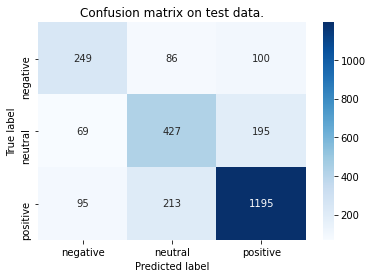

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Khai bao pre-trained
model = AutoModelForSequenceClassification.from_pretrained('FPTAI/vibert-base-cased', num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('FPTAI/vibert-base-cased')

# encoding du lieu
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

# Chuan bi mo hinh
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

# Huấn luyện mô hình
trainer.train()

train_dataset_pred = trainer.predict(train_dataset)
dev_dataset_pred = trainer.predict(dev_dataset)
test_dataset_pred = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_dataset_pred.predictions, axis=-1)
y_dev_pred = np.argmax(dev_dataset_pred.predictions, axis=-1)
y_test_pred = np.argmax(test_dataset_pred.predictions, axis=-1)

y_train_true = train_dataset_pred.label_ids
y_dev_true = dev_dataset_pred.label_ids
y_test_true = test_dataset_pred.label_ids

# Danh gia mo hinh
acc_train = accuracy_score(y_train_true, y_train_pred)
acc_dev = accuracy_score(y_dev_true, y_dev_pred)
acc_test = accuracy_score(y_test_true, y_test_pred)
f1_macro_test = f1_score(y_test_true, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test_true, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test_true, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test_true, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test_true, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test_true, y_test_pred, average='micro')
cm = confusion_matrix(y_test_true, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu dự đoán
result = pd.DataFrame([X_test, y_test_true, y_test_pred]).T
result.columns = ['text', 'true_label', 'pred_label']
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Predict CSV/APD_Process/Head'
result.to_csv(path + '/' + 'vibert-base-cased.csv', index=False)
result.head()

# Lưu record
df = pd.DataFrame({"Model": [model_name[12]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

# BERT vinai/phobert-base

https://huggingface.co/vinai/phobert-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7cmbiecd


storing https://huggingface.co/vinai/phobert-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/a596f267f08b7158c7ab6300b1bf98eb6e1b05e6bcb0d7c18a8070364ee3011b.bbe27b2cac909b2279c83792c2d2b6f159f0a95f5d1c1eb66451da1c89a53609
creating metadata file for /root/.cache/huggingface/transformers/a596f267f08b7158c7ab6300b1bf98eb6e1b05e6bcb0d7c18a8070364ee3011b.bbe27b2cac909b2279c83792c2d2b6f159f0a95f5d1c1eb66451da1c89a53609
loading configuration file https://huggingface.co/vinai/phobert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a596f267f08b7158c7ab6300b1bf98eb6e1b05e6bcb0d7c18a8070364ee3011b.bbe27b2cac909b2279c83792c2d2b6f159f0a95f5d1c1eb66451da1c89a53609
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  

storing https://huggingface.co/vinai/phobert-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8363542cfd9e2bad1a9a618e87ea1153d84819a3ae581cff0816a2c1f610f433.42a5e558f15db4cc3af338445707272b8f7545df78efdc125d3fd51025b22d85
creating metadata file for /root/.cache/huggingface/transformers/8363542cfd9e2bad1a9a618e87ea1153d84819a3ae581cff0816a2c1f610f433.42a5e558f15db4cc3af338445707272b8f7545df78efdc125d3fd51025b22d85
loading weights file https://huggingface.co/vinai/phobert-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8363542cfd9e2bad1a9a618e87ea1153d84819a3ae581cff0816a2c1f610f433.42a5e558f15db4cc3af338445707272b8f7545df78efdc125d3fd51025b22d85


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

storing https://huggingface.co/vinai/phobert-base/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/970c6224b2713c8b52a7bcfc4d5a951c9bb88302e4523388b50f28284e87ac44.26ba0c8945e559c68d0bc35d24fea16f5463a49fe8f134e0c32261d590b577fa
creating metadata file for /root/.cache/huggingface/transformers/970c6224b2713c8b52a7bcfc4d5a951c9bb88302e4523388b50f28284e87ac44.26ba0c8945e559c68d0bc35d24fea16f5463a49fe8f134e0c32261d590b577fa
https://huggingface.co/vinai/phobert-base/resolve/main/bpe.codes not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbkw5ylr2


storing https://huggingface.co/vinai/phobert-base/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/f3a66ae0a78d1a53b3eb99e31837d0d8e2f684a2dcc1f52f75fd36873e3d79de.301ac8958de708ddcea8500d9acbe6261dba391d249c98dcda1e49dbbff870dd
creating metadata file for /root/.cache/huggingface/transformers/f3a66ae0a78d1a53b3eb99e31837d0d8e2f684a2dcc1f52f75fd36873e3d79de.301ac8958de708ddcea8500d9acbe6261dba391d249c98dcda1e49dbbff870dd


loading file https://huggingface.co/vinai/phobert-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/970c6224b2713c8b52a7bcfc4d5a951c9bb88302e4523388b50f28284e87ac44.26ba0c8945e559c68d0bc35d24fea16f5463a49fe8f134e0c32261d590b577fa
loading file https://huggingface.co/vinai/phobert-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/f3a66ae0a78d1a53b3eb99e31837d0d8e2f684a2dcc1f52f75fd36873e3d79de.301ac8958de708ddcea8500d9acbe6261dba391d249c98dcda1e49dbbff870dd
loading file https://huggingface.co/vinai/phobert-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/vinai/phobert-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer.json from cache at None
Adding <mask> to the vocabulary
Special tokens have b

Step,Training Loss
500,0.876400
1000,0.692000
1500,0.608600
2000,0.506400
2500,0.409600
3000,0.338600
3500,0.256000
4000,0.210100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

***** Running Prediction *****
  Num examples = 1053
  Batch size = 16
***** Running Prediction *****
  Num examples = 2629
  Batch size = 16


Accuracy train:  0.9659547473038698
Accuracy dev:  0.7454890788224121
Accuracy test:  0.7474324838341575
F1 macro test:  0.7080915332407036
Recall macro test:  0.7072872060050654
Precision macro test:  0.710024491613037
F1 micro test:  0.7474324838341576
Recall micro test:  0.7474324838341575
Precision micro test:  0.7474324838341575


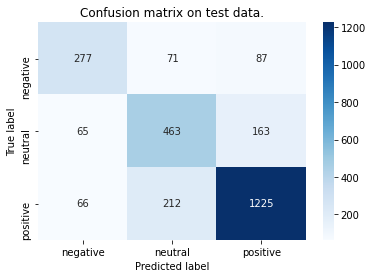

IndexError: ignored

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Khai bao pre-trained
model = AutoModelForSequenceClassification.from_pretrained('vinai/phobert-base', num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

# encoding du lieu
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

# Chuan bi mo hinh
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

# Huấn luyện mô hình
trainer.train()

train_dataset_pred = trainer.predict(train_dataset)
dev_dataset_pred = trainer.predict(dev_dataset)
test_dataset_pred = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_dataset_pred.predictions, axis=-1)
y_dev_pred = np.argmax(dev_dataset_pred.predictions, axis=-1)
y_test_pred = np.argmax(test_dataset_pred.predictions, axis=-1)

y_train_true = train_dataset_pred.label_ids
y_dev_true = dev_dataset_pred.label_ids
y_test_true = test_dataset_pred.label_ids

# Danh gia mo hinh
acc_train = accuracy_score(y_train_true, y_train_pred)
acc_dev = accuracy_score(y_dev_true, y_dev_pred)
acc_test = accuracy_score(y_test_true, y_test_pred)
f1_macro_test = f1_score(y_test_true, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test_true, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test_true, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test_true, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test_true, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test_true, y_test_pred, average='micro')
cm = confusion_matrix(y_test_true, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu dự đoán
result = pd.DataFrame([X_test, y_test_true, y_test_pred]).T
result.columns = ['text', 'true_label', 'pred_label']
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Predict CSV/APD_Process/Head'
result.to_csv(path + '/' + 'phoBert.csv', index=False)
result.head()

# Lưu record
df = pd.DataFrame({"Model": [model_name[14]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          index = None, header = False, mode = 'a')

loading configuration file /content/drive/MyDrive/ver2/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.8.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading weights file /content/drive/MyDrive/ver2/pytorch_model.bin
Some weights of the model checkpoint at /content/drive/MyDrive/ver2 were

Step,Training Loss
500,0.821700
1000,0.584600
1500,0.379400
2000,0.200000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 9458
  Batch size = 16


***** Running Prediction *****
  Num examples = 1053
  Batch size = 16
***** Running Prediction *****
  Num examples = 2629
  Batch size = 16


Accuracy train:  0.9718756608162402
Accuracy dev:  0.7008547008547008
Accuracy test:  0.7303157093952073
F1 macro test:  0.677809927918692
Recall macro test:  0.6723484813396312
Precision macro test:  0.684379120046401
F1 micro test:  0.7303157093952074
Recall micro test:  0.7303157093952073
Precision micro test:  0.7303157093952073


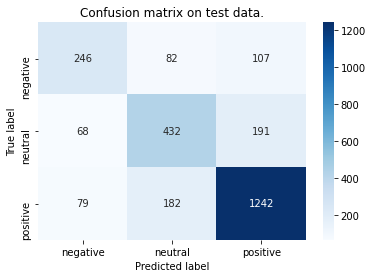

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Khai bao pre-trained
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/ver2', num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/ver2')

# encoding du lieu
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
dev_encodings = tokenizer(list(X_dev), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

# Chuan bi mo hinh
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 7,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

# Huấn luyện mô hình
trainer.train()

train_dataset_pred = trainer.predict(train_dataset)
dev_dataset_pred = trainer.predict(dev_dataset)
test_dataset_pred = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_dataset_pred.predictions, axis=-1)
y_dev_pred = np.argmax(dev_dataset_pred.predictions, axis=-1)
y_test_pred = np.argmax(test_dataset_pred.predictions, axis=-1)

y_train_true = train_dataset_pred.label_ids
y_dev_true = dev_dataset_pred.label_ids
y_test_true = test_dataset_pred.label_ids

# Danh gia mo hinh
acc_train = accuracy_score(y_train_true, y_train_pred)
acc_dev = accuracy_score(y_dev_true, y_dev_pred)
acc_test = accuracy_score(y_test_true, y_test_pred)
f1_macro_test = f1_score(y_test_true, y_test_pred, average='macro')
recall_macro_test = recall_score(y_test_true, y_test_pred, average='macro')
precision_macro_test = precision_score(y_test_true, y_test_pred, average='macro')
f1_micro_test = f1_score(y_test_true, y_test_pred, average='micro')
recall_micro_test = recall_score(y_test_true, y_test_pred, average='micro')
precision_micro_test = precision_score(y_test_true, y_test_pred, average='micro')
cm = confusion_matrix(y_test_true, y_test_pred)
print('=================================================================================')
print('Accuracy train: ', acc_train)
print('Accuracy dev: ', acc_dev)
print('Accuracy test: ', acc_test)
print('F1 macro test: ', f1_macro_test)
print('Recall macro test: ', recall_macro_test)
print('Precision macro test: ', precision_macro_test)
print('F1 micro test: ', f1_micro_test)
print('Recall micro test: ', recall_micro_test)
print('Precision micro test: ', precision_micro_test)
list_labels = ['negative', 'neutral', 'positive']
sb.heatmap(cm, annot = True, fmt = 'g', cmap = 'Blues', annot_kws = {"size": 10}, 
           xticklabels = list_labels, yticklabels = list_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix on test data.')
plt.show()

# Lưu dự đoán
result = pd.DataFrame([X_test, y_test_true, y_test_pred]).T
result.columns = ['text', 'true_label', 'pred_label']
path = '/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Predict CSV/APD_Process/Head'
#result.to_csv(path + '/' + 'xlm-r.csv', index=False)
result.head()

# Lưu record
df = pd.DataFrame({"Model": [model_name[11]],
                   "ACC_TRAIN": [acc_train],
                   "ACC_DEV": [acc_dev],
                   "ACC_TEST": [acc_test],
                   "PRECISION-MACRO": [precision_macro_test],
                   "RECALL-MACRO":[recall_macro_test],
                    "F1-MACRO": [f1_macro_test],
                    "PRECISION-MICRO": [precision_micro_test], 
                    "RECALL-MICRO":[recall_micro_test],
                    "F1-MICRO": [f1_micro_test]})
#df.to_csv("/content/drive/MyDrive/NLP for Data Science/NLP_Project/Source Code/Evaluate/APD_Process/Head/APD_Process_head.csv",
          #index = None, header = False, mode = 'a')